In [19]:
import sys
sys.path.append("..")

# basics
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import copy
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import utils.floquet_solver as fsolver
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver
import utils.floquetify as floqify


# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

pass

10.0%. Run time:   0.48s. Est. time left: 00:00:00:04
20.0%. Run time:   0.95s. Est. time left: 00:00:00:03
30.0%. Run time:   1.36s. Est. time left: 00:00:00:03
40.0%. Run time:   1.78s. Est. time left: 00:00:00:02
50.0%. Run time:   2.19s. Est. time left: 00:00:00:02
60.0%. Run time:   2.59s. Est. time left: 00:00:00:01
70.0%. Run time:   2.93s. Est. time left: 00:00:00:01
80.0%. Run time:   3.28s. Est. time left: 00:00:00:00
90.0%. Run time:   3.66s. Est. time left: 00:00:00:00
Total run time:   4.10s


0.6780023021566872

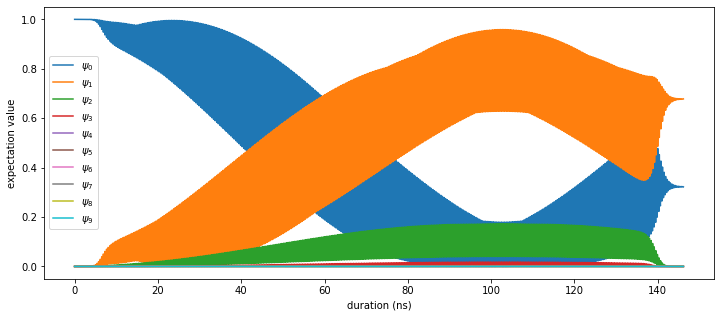

In [26]:
# sample system
amplitude = 7.034040495797981
duration = 146.17831127951132
off = 0.10188603062894215
freq = system.first_energy_spacing/3 - off
tlist = np.arange(0, duration, (2*np.pi)/(freq*20))
ramp_slope = 0.5
cut_factor = 3
tanh.setup(amplitude, freq, ramp_slope, cut_factor, tlist)

s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True, store_states=True)
# s = fsolver.time_evolve(system.H0, system.H1, tanh, 20, 20, (2*np.pi)/freq, tlist, system.starting_state)
graph.graph_solution(s, system) # only graphs the end of it
fidelity = expv.expectation_value(s.final_state, system.basis_states[1])
fidelity

In [6]:
# generate chevrons

def inner(dur):
    global t_multiplier, amplitude, freq, ramp_slope
    tlist = np.linspace(0, dur, int(dur*t_multiplier + t_multiplier))
    tanh.setup(amplitude=amplitude, drive_frequency=freq, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    ramp_time = 16 # roughly 13, but this makes it even closer to correct
    s = fsolver.time_evolve(system.H0, system.H1, tanh, ramp_time, ramp_time, ((2*np.pi)/freq), tlist, system.starting_state)
    # s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
    fidelity = expv.expectation_value(s.states[-1], system.target_state)
    return fidelity

def generate_fidelity_landscape(_amplitude, freq_list, dur_list, _t_multiplier=5, skip_rate=1):
    global t_multiplier, amplitude, freq, ramp_slope
    t_multiplier = _t_multiplier
    amplitude = _amplitude
    fids = [] # an array of columns in the landscape
    freq_points = np.linspace(np.amin(freq_list), np.amax(freq_list), int(len(freq_list)/skip_rate))
    dur_points = np.linspace(np.amin(dur_list), np.amax(dur_list), int(len(dur_list)/skip_rate))
    for f in tqdm(freq_points):
        freq = f
        # in parallel
        fids.append(parallel_map(inner, dur_points))

        # sync
        # temp_fids = []
        # for dur in dur_points:
        #     temp_fids.append(inner(dur))
        # fids.append(temp_fids)

    fids = np.swapaxes(fids,0,1)

    plt.pcolormesh(freq_points, dur_points, fids, shading='auto')
    plt.colorbar()
    plt.xlabel("frequency (angular GHz)")
    plt.ylabel("duration (ns)")
    
    return fids 

# Get Rabi Oscillation timing from distance between fringes

100%|██████████| 50/50 [14:29<00:00, 17.39s/it]


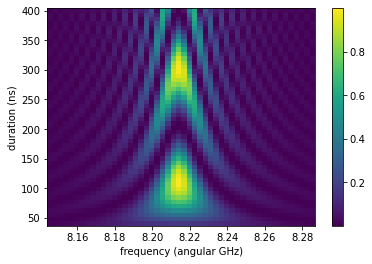

In [7]:
freq_list = np.linspace(freq-0.07, freq+0.07, 50)
dur_list = np.linspace(40, 400, 50)
fid_list = generate_fidelity_landscape(amplitude, freq_list, dur_list)

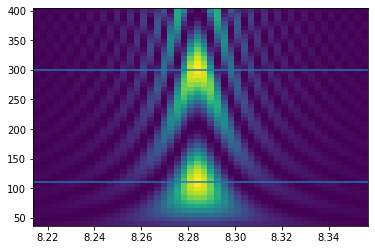

In [16]:
plt.pcolormesh(freq_list, dur_list, fid_list, shading="auto")
plt.axhline(111)
plt.axhline(300)
plt.show()

In [44]:
(1 / (300 - 111)) * 1000 # MHz

5.291005291005291

# Get Rabi Oscillation timing from quasi energies

In [30]:
floquet_results = floqify.floquetify(system, s, tanh, tlist)

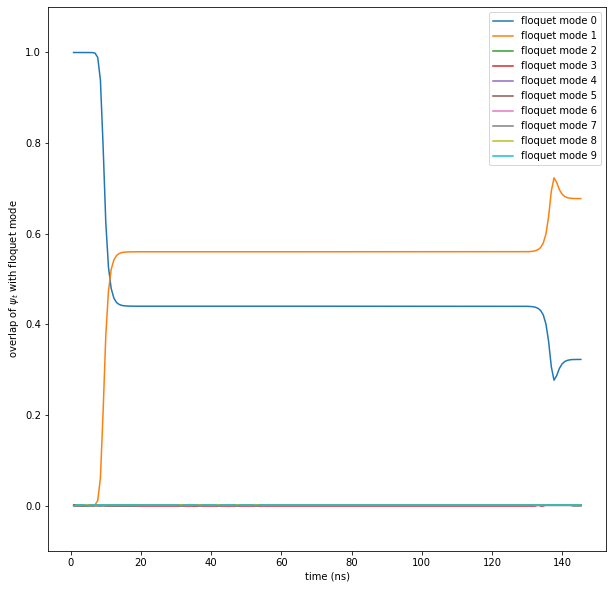

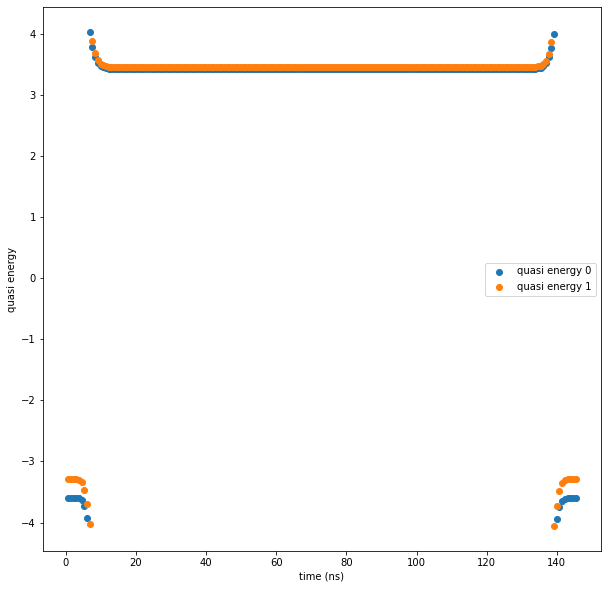

In [33]:
plt.figure(figsize=(10,10))
for i in range(0, len(floquet_results["expectation_values"])):
    o = floquet_results["expectation_values"][i]
    plt.plot(floquet_results["dur_points"], o, label=r'floquet mode %i' % i)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.scatter(floquet_results["dur_points"], np.array(floquet_results["ordered_energies"])[:,i], label=r'quasi energy %i' % i)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'quasi energy')
plt.show()

In [39]:
(np.array(floquet_results["ordered_energies"])[:,0][100]) - (np.array(floquet_results["ordered_energies"])[:,1][100])


-0.03300772482064529